## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel, TFAutoModel, ElectraModel, ElectraTokenizer
from transformers import TFElectraModel
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
strategy = tf.distribute.get_strategy()

## Load Dataset

In [3]:
train = pd.read_csv("../dataset/train.csv", encoding='CP949')
test = pd.read_csv("../dataset/test.csv", encoding='CP949')
sub = pd.read_csv("../dataset/test.csv", encoding='CP949')
train_snli = pd.read_csv('../dataset/kornli/snli_1.0_train.ko.tsv', delimiter='\t')
train_multinli = pd.read_csv('../dataset/kornli/multinli.train.ko.tsv', delimiter='\t', error_bad_lines= False)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 24426: expected 3 fields, saw 4\nSkipping line 156343: expected 3 fields, saw 4\nSkipping line 218766: expected 3 fields, saw 4\nSkipping line 232318: expected 3 fields, saw 4\nSkipping line 253493: expected 3 fields, saw 4\n'
b'Skipping line 265734: expected 3 fields, saw 4\nSkipping line 282588: expected 3 fields, saw 4\nSkipping line 350969: expected 3 fields, saw 4\n'


## EDA

### .head() 함수로 데이터셋에 대한 기본 정보 확인

In [4]:
train.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment


In [5]:
test.head()

,index,premise,hypothesis
0,1,진짜 사람하나 캐리어하나만 들어갈수있어요,캐리어는 들어갈 수 없어요.
1,2,그린 아메리카는 우선 대형 초콜릿 제조업체들을 대상으로 설득작업을 벌이고 있습니다.,초콜릿을 만드는 대형 제조업체가 존재한다.
2,3,또한 강연이 끝난 후 각 국의 업무 담당자들로부터 사전 접수한 질문과 함께 현장에서...,질의응답에 사전 접수된 질문은 답변이 제한된다.
3,4,수험생들은 각 상담부스에서 입시전문가나 입학사정관과 상담함으로써 수시모집 지원전략을...,수험생들은 입시전문가와 입학사정관에게 수시모집 지원전략에 대한 도움을 받을 수 있다.
4,5,콜린은 매우 친절하고 응답이 빠릅니다.,콜린이 숙소의 호스트입니다.


In [6]:
train_snli.head()

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment


In [7]:
train_snli.rename(columns={'sentence1':'premise', 'sentence2':'hypothesis', 'gold_label':'label'}, inplace=True)

In [8]:
train_multinli.rename(columns={'sentence1':'premise', 'sentence2':'hypothesis', 'gold_label':'label'}, inplace=True)

In [9]:
train_snli.head()

,premise,hypothesis,label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment


In [10]:
train_multinli.head()

,premise,hypothesis,label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral


train 19996개, test 5000개

In [11]:
print(f"train shape => {train.shape} \ntest shape => {test.shape} \
\n snli shape => {train_snli.shape} \n multinli shape => {train_multinli.shape}")

train shape => (19996, 4) 
test shape => (5000, 3) 
 snli shape => (550152, 3) 
 multinli shape => (385494, 3)


In [12]:
train.columns

Index(['index', 'premise', 'hypothesis', 'label'], dtype='object')

In [13]:
train = pd.concat([train, train_multinli], ignore_index=True)

In [14]:
len(train)

405490

In [15]:
# train = train.iloc[:30000]

In [16]:
train.head()

,index,premise,hypothesis,label
0,1.0,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,2.0,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,3.0,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,4.0,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,5.0,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment


In [17]:
train.tail()

,index,premise,hypothesis,label
405485,NaN,"분명히, 캘리포니아는 더 잘 할 수 있고, 더 잘해야 한다.",캘리포니아는 더 잘할 수 없다.,contradiction
405486,NaN,"한때 유럽에서 가장 아름다운 거리로 여겨졌는데, 이는 원래의 많은 건물들이 교체되었...",그래서 원래의 많은 건물들이 편의점으로 대체되었다.,neutral
405487,NaN,하우스보트는 영국 라지의 전성기의 아름답게 보존된 전통이다.,하우스보트의 전통은 영국 라지가 여전히 강해지는 동안 시작되었다.,entailment
405488,NaN,사망 기사는 그의 평론가의 신디케이트 TV 쇼에서 동료 검토 자 Roger Eber...,부고문은 아름다웠고 연예계에서의 그의 업적에 대해 현물로 쓰여졌다.,neutral
405489,NaN,"내가 해야 한다는 걸 알거나, 아니면 누가 하라고 하는 것보다 그녀를 밀고하는 것에...",남편이 요즘 너무 과로해서 이 근처에서 많은 일을 부탁할 용기가 나지 않는다.,neutral


In [18]:
train = train.drop(['index'], axis=1)

In [19]:
train.label.values

array(['contradiction', 'entailment', 'neutral', ..., 'entailment',
       'neutral', 'neutral'], dtype=object)

### 훈련데이터 결측치 계산

In [20]:
train.isnull().sum()

premise        0
hypothesis    40
label         63
dtype: int64

In [21]:
train.dropna(inplace=True)

In [22]:
train.isnull().sum()

premise       0
hypothesis    0
label         0
dtype: int64

### LabelEncoder를 활용해 categorical features를 encode함
contradiction => 0  
entailment => 1  
neutral => 2

In [23]:
categorical_cols = ['label']
for e in categorical_cols:
    le = LabelEncoder()
    train[e] = le.fit_transform(train[e])

In [24]:
train.head()

,premise,hypothesis,label
0,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,0
1,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,1
2,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,2
3,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,2
4,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,1


### 라벨값이 balaced 한지 imbalanced 한지 확인하는 visualization
만약 학습 데이터가 imbalanced 하다면, 추가적인 고민이 필요하지만  
시각화 결과 클래스 값들이 고르게 분포되어 있음.

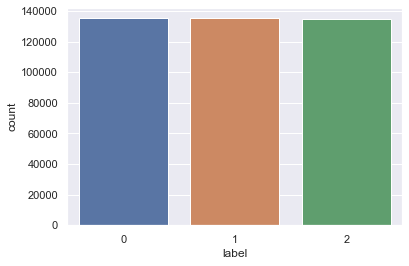

In [25]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

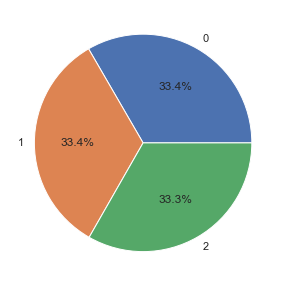

In [26]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## Modeling - KoELECTRA

In [27]:
def model_KoELECTRA():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [28]:
model = model_KoELECTRA()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'electra.embeddings.position_ids']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [29]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [30]:
train_data = train[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

### 패딩 적절 길이 구하기

In [31]:
len(train)

405387

In [32]:
len(train_data)

405387

In [33]:
train_encoded = tokenizer.batch_encode_plus(train_data)
test_encoded = tokenizer.batch_encode_plus(test_data)

Token indices sequence length is longer than the specified maximum sequence length for this model (2084 > 512). Running this sequence through the model will result in indexing errors


In [34]:
cal_length = train_encoded['input_ids'] + test_encoded['input_ids']

num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

토큰 길이 평균: 47.543440703531054
토큰 길이 최대: 8378
토큰 길이 표준편차: 47.622984821853095


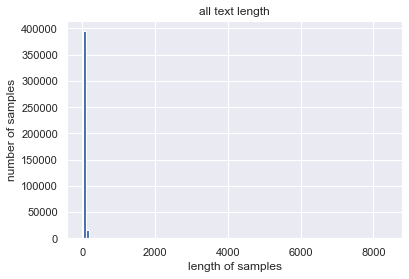

In [35]:
plt.title('all text length')
plt.hist(num_tokens, bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [36]:
select_length = 100

In [37]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, cal_length)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 0.9809545624008558


In [38]:
temp = []
for i in range(len(train_encoded['input_ids'])):
    if len(train_encoded['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del train_data[i]
    train.drop(train.index[i], inplace=True)
    
temp = []
for i in range(len(test_encoded['input_ids'])):
    if len(test_encoded['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del test_data[i]

In [39]:
len(train_data)

397571

In [40]:
len(train)

397571

In [41]:
len(test_data)

5000

### 최종 모델링

In [42]:
train_encoded = tokenizer.batch_encode_plus(train_data, padding='max_length', max_length=100)
test_encoded = tokenizer.batch_encode_plus(test_data, padding='max_length', max_length=100)

In [43]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded['input_ids'], train.label.values, test_size=0.2, stratify=train.label.values)
x_test = test_encoded['input_ids']

In [44]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 100)]             0         
_________________________________________________________________
tf_electra_model (TFElectraM TFBaseModelOutputWithPast 112330752 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2307      
Total params: 112,333,059
Trainable params: 112,333,059
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

history = model.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,validation_data=valid_dataset,epochs= 10)

Epoch 1/10
19878/19878 [==============================] - 4382s 220ms/step - loss: 0.5388 - accuracy: 0.7827 - val_loss: 0.4930 - val_accuracy: 0.8093
Epoch 2/10
19878/19878 [==============================] - 4376s 220ms/step - loss: 0.3931 - accuracy: 0.8486 - val_loss: 0.5309 - val_accuracy: 0.8159
Epoch 3/10
19878/19878 [==============================] - 4377s 220ms/step - loss: 0.2926 - accuracy: 0.8907 - val_loss: 0.6128 - val_accuracy: 0.8086
Epoch 4/10
19878/19878 [==============================] - 4375s 220ms/step - loss: 0.2168 - accuracy: 0.9211 - val_loss: 0.6977 - val_accuracy: 0.8040
Epoch 5/10
19878/19878 [==============================] - 4357s 219ms/step - loss: 0.1580 - accuracy: 0.9438 - val_loss: 0.7974 - val_accuracy: 0.8037
Epoch 6/10
 8440/19878 [===========>..................] - ETA: 39:11 - loss: 0.1288 - accuracy: 0.9543

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(test_dataset, verbose=1)

In [ ]:
predictions_final = predictions.argmax(axis=1)

In [ ]:
len(predictions_final)

In [ ]:
list1 = [i for i in range(5000)]

In [ ]:
list2 = predictions_final

In [ ]:
submission = pd.DataFrame({'index':list1,
                           'label':list2})

In [ ]:
submission

In [ ]:
# contradiction => 0 entailment => 1 neutral => 2
submission['label'].replace(0, 'contradiction', inplace=True)
submission['label'].replace(1, 'entailment', inplace=True)
submission['label'].replace(2, 'neutral', inplace=True)

In [ ]:
submission

## versus previous submission(v4)

In [ ]:
previous = pd.read_csv('../submission/submission_KoELECTRAv4.csv')

In [ ]:
previous['label']

In [ ]:
submission['label']

In [ ]:
cnt_equal = 0
cnt_diff = 0
for i in range(5000):
    if previous['label'][i] == submission['label'][i]:
        cnt_equal += 1
    else: cnt_diff += 1

similarity = cnt_equal/(cnt_equal+cnt_diff) * 100
print(f"이전 제출 파일과의 유사도:{similarity}%")

In [ ]:
submission.to_csv("../submission/submission_KoELECTRAv5.csv", index = False)

In [ ]:
# model.save('competition_KoELECTRA_v2.h5')
# Load model code
# new_model = tf.keras.models.load_model('competition_BERT_v1.h5')
# test_loss, test_acc = new_model.evaluate(x,  y, verbose=2)